In [2]:
import sys
import os
import numpy as np
import supervision as sv
import math
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from plotly.subplots import make_subplots

src_path = os.path.abspath(os.path.join('../../../../', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    

from tools.data_processor import DataProcessor
from tools.frame_processors import SupervisionVertexProcessorWithLandmarkFrontalization
from tools.frame_preprocessors import TextureFrontalizationPreprocessor, FaceExtractionPreprocessor

In [3]:
EXPRESSIONS_PATH = os.path.abspath(os.path.join('..', '..', 'data', 'expressions'))
REFERENCE_POINTS = "key_points_xyz.npy"
REFERENCE_POINTS_PATH = os.path.abspath(os.path.join('..', '..', '..', '..', 'data', 'reference_points', REFERENCE_POINTS))
MODELS_PATH = os.path.join(src_path, "models", "frontalization_models")

In [4]:
class SVPWLF_dummy(SupervisionVertexProcessorWithLandmarkFrontalization):
    def __init__(self, reference_points_path: str):
        super().__init__(reference_points_path)
        self.keypoints_history = []
    
    def process(self, frame: np.ndarray) -> np.ndarray:        
        processed_frame = self._model.process(frame)
        image_to_frontalize_xyz = self._get_xyz_from_processed_frame(processed_frame)
        frontalized_keypoints = self._procrustes_analysis(
            image_to_frontalize_xyz[0], self._reference_points[0]
        )
        frontalized_keypoints = self._get_xy_from_xyz(frontalized_keypoints)
        
        self.keypoints_history.append(frontalized_keypoints)

        return self._make_face_mesh(frontalized_keypoints)

In [5]:
class DataProcessor_dummy(DataProcessor):
    def process_video(
        self,
        source_path: str,
        target_path: str = None,
    ):
        """
        Overrides the regular process_video to not display the output frame but rather show
        the accumulated landmark data.

        Args:
            source_path (str): The path to the source video.
            target_path (str): The path to the target video
        """
        for frame in sv.get_video_frames_generator(source_path):
            annotated_frame = self._handle_frame(frame)
            if annotated_frame is None:
                continue
        
        return self._frame_processor.keypoints_history


In [6]:
def get_average_landmarks_distance(video_path: str, landmark_indexes: list, reference_landmark_index: list):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        distance_sum = 0
        for landmark_idx in landmark_indexes:
            distance_sum += math.sqrt(
                (keypoint[reference_landmark_index][0] - keypoint[landmark_idx][0])**2 +
                (keypoint[reference_landmark_index][1] - keypoint[landmark_idx][1])**2
            )
        output.append(distance_sum / len(landmark_indexes))

    return output

In [7]:
emotions_distance = {}

## All landmarks

In [8]:
LANDMARK_INDEXES = [
    76, 306,  # mouth corners
    74, 73, 72, 11, 302, 303, 304, # upper lip
    90, 180, 85, 16, 315, 404, 320, # lower lip
    33, 161, 159, 157, 133, 154, 145, 163,  # left eye
    70, 63, 105, 66, 107,  # left eyebrow
    362, 384, 386, 388, 263, 390, 374, 381,  # right eye
    300, 293, 334, 296, 336,  # right eyebrow
    1, 5, 197, 168  # nose
]

REFERENCE_LANDMARK_INDEX = 0  # Middle of face

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_distance:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_distance[emotion] = get_average_landmarks_distance(emotion_video, LANDMARK_INDEXES, REFERENCE_LANDMARK_INDEX)

Processing videos: 100%|██████████| 6/6 [02:25<00:00, 24.17s/it]


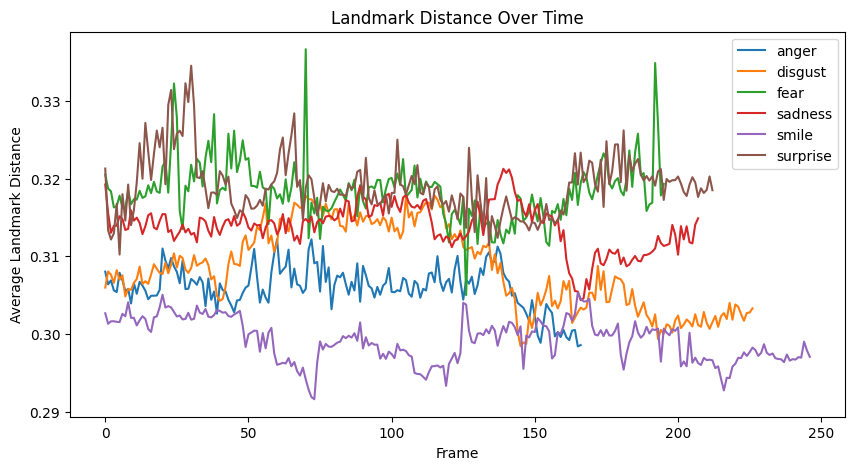

In [9]:
plt.figure(figsize=(10, 5))

for emotion, distances in emotions_distance.items():
    plt.plot(distances, label=emotion)

plt.xlabel('Frame')
plt.ylabel('Average Landmark Distance')
plt.title('Landmark Distance Over Time')
plt.legend()
plt.show()

## Particular face part movement over time

In [10]:
def get_average_landmarks_distance_areas(video_path: str, landmark_areas_indexes: dict, reference_landmark_index: list):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        distances = defaultdict(lambda: 0)
        for area, landmark_idxs in landmark_areas_indexes.items():
            for landmark_idx in landmark_idxs:
                distances[area] += math.sqrt(
                    (keypoint[reference_landmark_index][0] - keypoint[landmark_idx][0])**2 +
                    (keypoint[reference_landmark_index][1] - keypoint[landmark_idx][1])**2
                )
        output.append({area: distance / len(landmark_areas_indexes[area]) for area, distance in distances.items()})

    return output

In [11]:
LANDMARKS = {
    "mouth": [
        76, 306,  # mouth corners
        74, 73, 72, 11, 302, 303, 304, # upper lip
        90, 180, 85, 16, 315, 404, 320 # lower lip
    ],
    "eyes": [
        33, 161, 159, 157, 133, 154, 145, 163,  # left eye
        362, 384, 386, 388, 263, 390, 374, 381  # right eye
    ],
    "eyebrows": [
        70, 63, 105, 66, 107,  # left eyebrow
        300, 293, 334, 296, 336  # right eyebrow
    ]
}

REFERENCE_LANDMARK_INDEX = 0  # Middle of face

emotions_distance = {}

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_distance:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_distance[emotion] = get_average_landmarks_distance_areas(emotion_video, LANDMARKS, REFERENCE_LANDMARK_INDEX)

Processing videos: 100%|██████████| 6/6 [02:16<00:00, 22.80s/it]


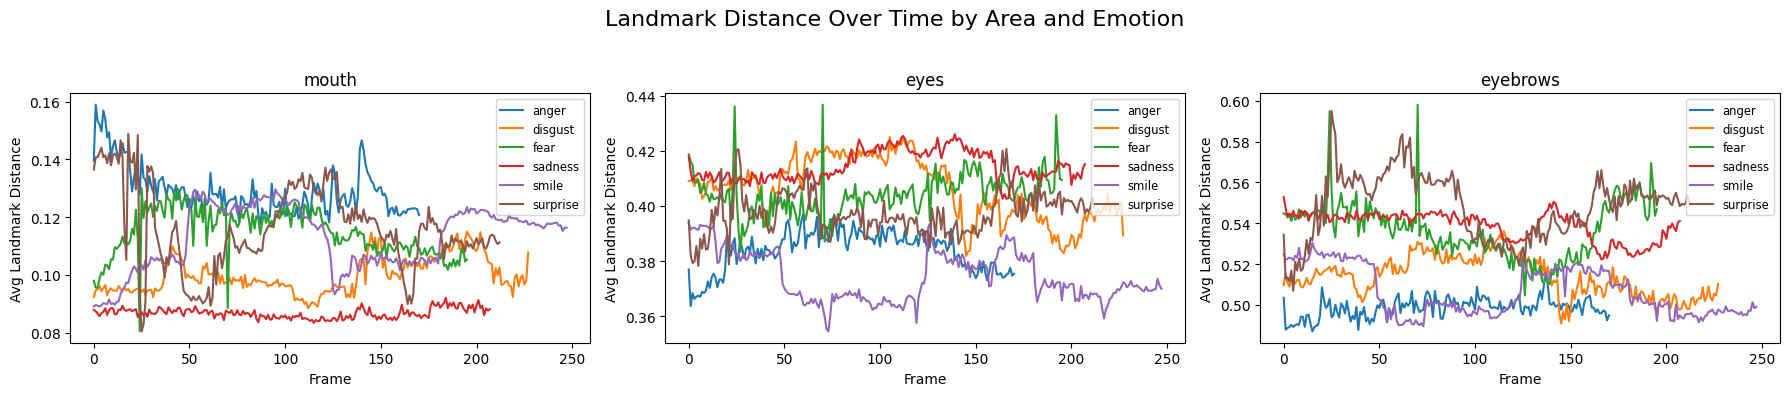

In [15]:
areas = list(LANDMARKS.keys())
n_areas = len(areas)
cols = 3
rows = (n_areas + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)

for idx, area in enumerate(areas):
    r, c = divmod(idx, cols)
    ax = axs[r][c]

    for emotion, distances in emotions_distance.items():
        area_distances = [d[area] for d in distances]
        ax.plot(area_distances, label=emotion)

    ax.set_title(f'{area}')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Avg Landmark Distance')
    ax.legend(fontsize='small')

# Ukryj puste subplots, jeśli są
for idx in range(n_areas, rows * cols):
    r, c = divmod(idx, cols)
    fig.delaxes(axs[r][c])

plt.suptitle('Landmark Distance Over Time by Area and Emotion', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 2d movement over time

In [17]:
def get_landmarks_2d_for_areas(video_path: str, landmark_areas_indexes: dict):
    dp = DataProcessor_dummy(
        frame_processor=SVPWLF_dummy(
            reference_points_path=REFERENCE_POINTS_PATH
        ),
        frame_preprocessors=[
            FaceExtractionPreprocessor(
                skip_bad_frames=True,
                output_size=(200, 200)
            ),
            TextureFrontalizationPreprocessor(
                models_path=MODELS_PATH,
                do_calculate_symmetry=True
            ),
        ],
    )
    keypoint_history = dp.process_video(video_path)

    output = []
    for keypoint in keypoint_history:
        coordinates = defaultdict(list)
        for area, landmark_idx in landmark_areas_indexes.items():
            coordinates[area].append(keypoint[landmark_idx])
        output.append(coordinates)

    return output

In [18]:
LANDMARKS_FOR_COORDS = {
    "mouth_c_l": 76,
    "mouth_c_r": 306,
    "mouth_u_1": 74,
    "mouth_u_2": 73,
    "mouth_u_3": 72,
    "mouth_u_4": 11,
    "mouth_u_5": 302,
    "mouth_u_6": 303,
    "mouth_u_7": 304,
    "mouth_d_1": 90,
    "mouth_d_2": 180,
    "mouth_d_3": 85,
    "mouth_d_4": 16,
    "mouth_d_5": 315,
    "mouth_d_6": 404,
    "mouth_d_7": 320,
}

emotions_landmarks_pos = {}

for emotion_video in tqdm(os.listdir(EXPRESSIONS_PATH), desc="Processing videos"):
    emotion = emotion_video.split('.')[0]
    
    if emotion not in emotions_landmarks_pos:
        emotion_video = os.path.join(EXPRESSIONS_PATH, emotion_video)
        emotions_landmarks_pos[emotion] = get_landmarks_2d_for_areas(emotion_video, LANDMARKS_FOR_COORDS)

Processing videos: 100%|██████████| 6/6 [02:16<00:00, 22.72s/it]


### Const plots

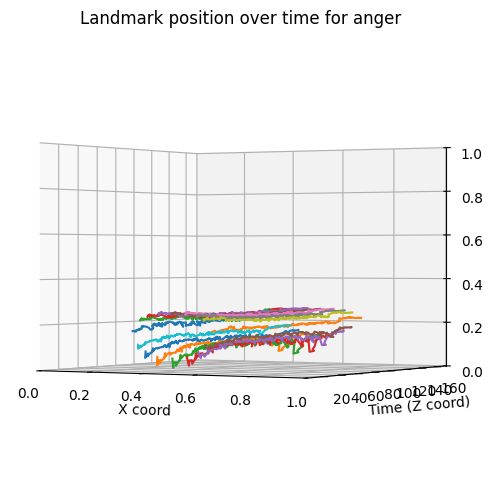

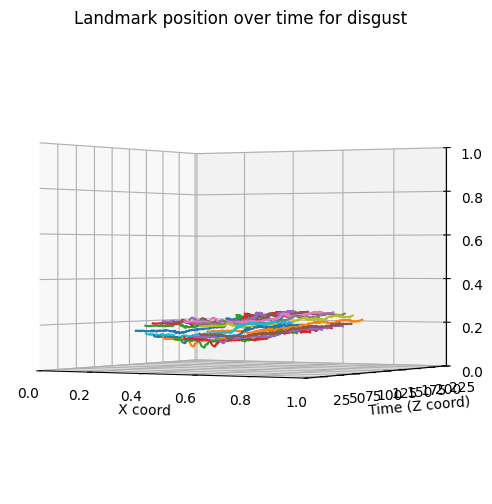

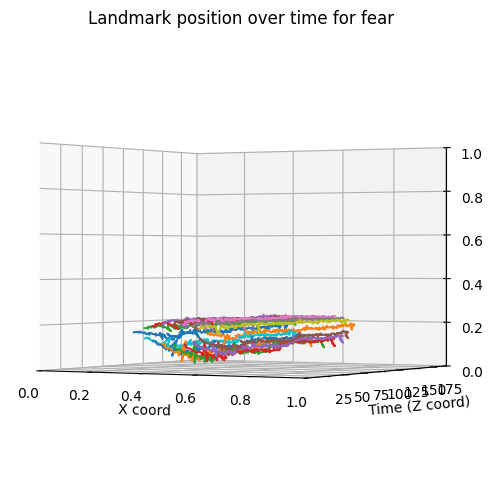

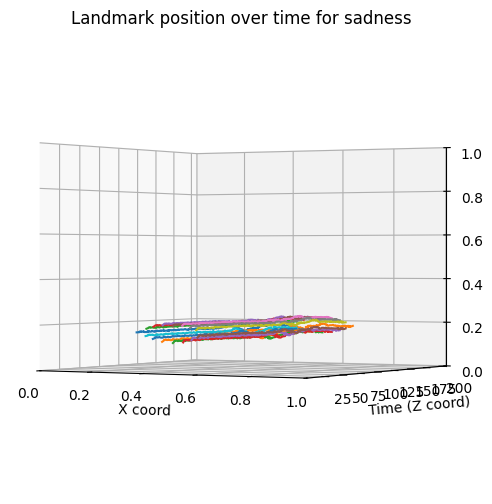

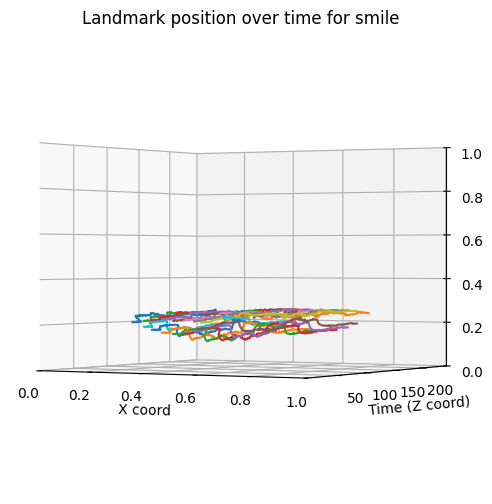

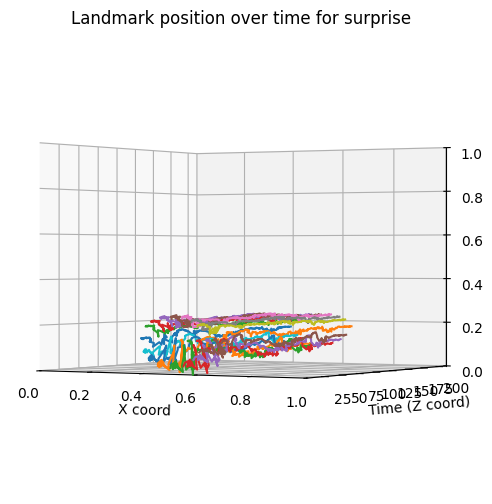

In [19]:
for emotion, coords_2d in emotions_landmarks_pos.items():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    z_values = np.arange(1, len(coords_2d) + 1)

    for area in LANDMARKS_FOR_COORDS.keys():
        area_coords_2d = [pos[area][0] for pos in coords_2d]
        x_coords = [c[0] for c in area_coords_2d]
        y_coords = [1 - c[1] for c in area_coords_2d]  # Invert Y-coordinates
        ax.plot(x_coords, z_values, y_coords, label=area)

    ax.set_xlim(0, 1)
    ax.set_ylim(1, len(coords_2d))
    ax.set_zlim(0, 1)
    ax.set_xlabel('X coord')
    ax.set_ylabel('Time (Z coord)')
    ax.set_zlabel('Y coord')
    ax.view_init(elev=0, azim=-60)
    ax.set_title(f'Landmark position over time for {emotion}')
    plt.show()

### Interactive plots

In [20]:
EMOTION = "smile"

In [23]:
for emotion, coords_2d in emotions_landmarks_pos.items():
    if emotion != EMOTION:
        continue

    # Create a color scale
    color_scale = px.colors.qualitative.Set1  # Use a qualitative color scale (e.g., Set1, Set2, etc.)
    # Dynamic color dictionary generation
    area_colors = {area: color_scale[i % len(color_scale)] for i, area in enumerate(LANDMARKS_FOR_COORDS.keys())}

    # Initialize figure with 3D and 2D subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter'}]],
        subplot_titles=("3D Landmark Animation", "2D Intersection Points")
    )

    # Add 3D scatter traces for each area
    z_values = np.arange(1, len(emotions_landmarks_pos[EMOTION]) + 1)
    for area in LANDMARKS_FOR_COORDS.keys():
        area_coords_2d = [pos[area][0] for pos in emotions_landmarks_pos[EMOTION]]
        x_coords = [c[0] for c in area_coords_2d]
        y_coords = [1 - c[1] for c in area_coords_2d]

        fig.add_trace(
            go.Scatter3d(
                x=x_coords,
                y=z_values,
                z=y_coords,
                mode='lines',
                name=area,
                line=dict(color=area_colors[area], width=3)  # Use the dynamic color from the dictionary
            ),
            row=1, col=1
        )

    # Prepare frames for the moving plane and 2D plot
    frames = []
    for t in range(1, len(emotions_landmarks_pos[EMOTION]) + 1):
        # Define the moving plane
        plane_z = np.array([[0, 1], [0, 1]])  # Define a simple 2x2 grid
        plane_x = np.array([[0, 0], [1, 1]])  # Same size for the plane
        plane_y = np.full_like(plane_x, t, dtype=float)  # Plane moves with time

        plane = go.Surface(
            z=plane_z,
            x=plane_x,
            y=plane_y,
            surfacecolor=np.full_like(plane_x, 0.5),  # Any constant value; color is controlled by colorscale
            colorscale=[[0, "grey"], [1, "grey"]],    # Solid grey
            opacity=0.8,
            showscale=False,                          # Hides the color scale bar
            name="Time Plane"
        )

        # Calculate intersection points for 2D plot
        intersection_points = []
        intersection_colors = []
        for area in LANDMARKS_FOR_COORDS.keys():
            area_coords_2d = [pos[area][0] for pos in emotions_landmarks_pos[EMOTION]]
            x_coords = [c[0] for c in area_coords_2d]
            y_coords = [1 - c[1] for c in area_coords_2d]

            # Filter points close to the current time step
            intersect_x = [x for x, z in zip(x_coords, z_values) if z == t]
            intersect_y = [y for y, z in zip(y_coords, z_values) if z == t]

            intersection_points.extend(list(zip(intersect_x, intersect_y)))
            intersection_colors.extend([area_colors[area]] * len(intersect_x))  # Assign the same color to all points of the area

        # Add intersection points to 2D plot
        intersect_trace = go.Scatter(
            x=[p[0] for p in intersection_points],
            y=[p[1] for p in intersection_points],
            mode='markers',
            marker=dict(
                size=10,
                color=intersection_colors,  # Assign the colors dynamically
                opacity=1
            )
        )

        # Add frame for this time step
        frames.append(go.Frame(
            data=[plane, intersect_trace],
            name=str(t)
        ))

    # Add the frames to the figure
    fig.frames = frames

    # Update layout with a slider to control the frames
    fig.update_layout(
        height=800,
        scene=dict(
            xaxis_title='X coord',
            yaxis_title='Time (Z coord)',
            zaxis_title='Y coord',
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[1, len(emotions_landmarks_pos[EMOTION])]),
            zaxis=dict(range=[0, 1]),
        ),
        sliders=[{
            "steps": [{
                "args": [
                    [str(t)],
                    {
                        "frame": {"duration": 300, "redraw": True},
                        "mode": "immediate",
                        "transition": {"duration": 300}
                    }
                ],
                "label": f"Time {t}",
                "method": "animate"
            } for t in range(1, len(emotions_landmarks_pos[EMOTION]) + 1)],
            "currentvalue": {"prefix": "Time Step: ", "visible": True, "xanchor": "center"},
        }],
        title=f"Landmark Position Over Time for {EMOTION}",
        margin=dict(l=0, r=0, b=0, t=40),
        xaxis=dict(range=[0, 1], title="X coord"),  # Fixed X axis range for 2D plot
        yaxis=dict(range=[0, 1], title="Y coord")   # Fixed Y axis range for 2D plot
    )

    fig.show()